# Understanding the Data

The data is defined by three cohorts: _Training_, _Test (Validation)_, and _Testing_. The _Testing_ dataset is kept private and is used to test the competition submission entries. The _Test_ dataset, available for use, represents about 20% the size of the private _Testing_ dataset. Each top level folder represents a subject idicated by a five digit number. Within each of the folders are the four different MRI tests, FLAIR, T1w, T1wCE, and T2w. Each of these test folders has the respective imgages in DICOM format. The Tests and data structure are as follows:

1.  **FLAIR** - Fluid Attenuated Inversion Recovery
2.  **T1w** - T1-weighted pre-contrast
    * fluid (black) - low signal intensity
    * fat (white) - high signal intensity
    * grey matter (grey) - intermediate signal intensity
    * white matter (white-ish)
3.  **T1wCE** - T1-weighted post-contrast
4.  **T2w** - T2-weighted 
    * fluid (white) - high signal intensity
    * fat (white) - high signal intensity
    * grey matter (grey) - intermediate signal intensity
    * white matter (black-ish)
    
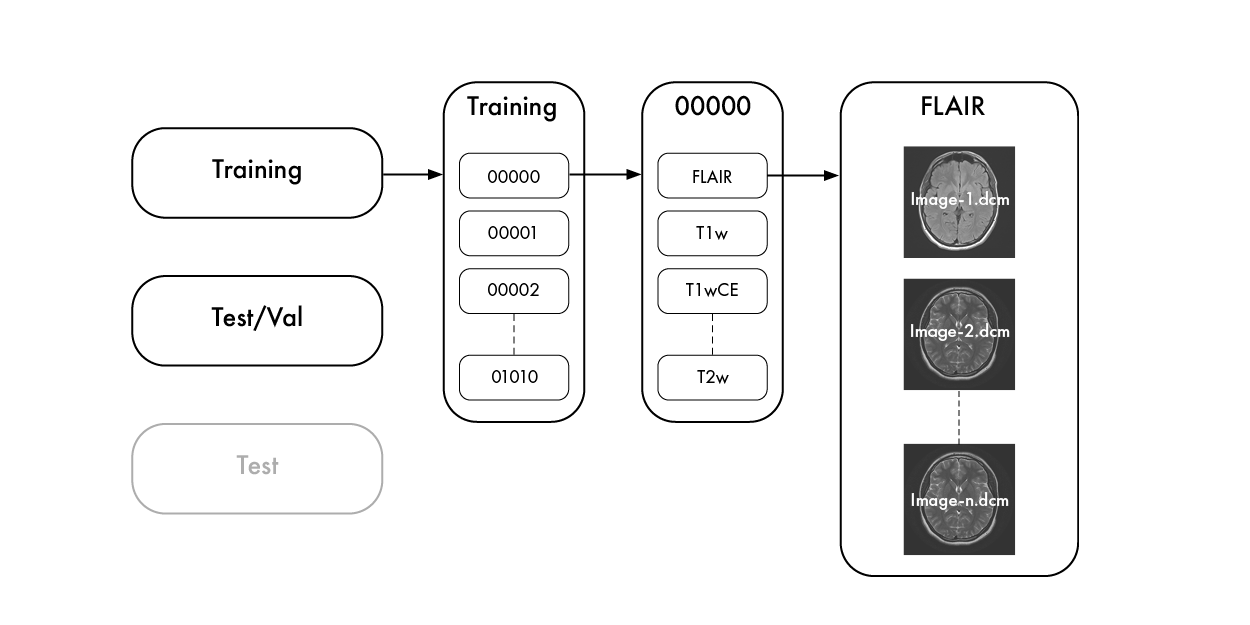  
    
**NOTE:** There are some unexpected issues with the following three cases in the training dataset, participants can exclude the cases during training:   
[00109, 00123, 00709]

In [ ]:
# necessary imports
import os
import io
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D 

In [ ]:
from efficientnet_pytorch_3d import EfficientNet3D

In [ ]:
labels_key = 'train_labels.csv'
train_key = 'train'
test_key = 'test'
data_dir = "../input/rsna-miccai-brain-tumor-radiogenomic-classification"
train_labels_df = pd.read_csv(os.path.join(data_dir, labels_key))
print("Num train labels: ", len(train_labels_df))
train_labels_df.head()

# Split the Data
In order to have a portion of the training data used for validation in training I am splitting the data to take a look at the distribution. The following function uses scikit learn to split the data. Splitting the data could be done in the Pytorch Dataloader or Dataset Class but that potentially could introduce class label bias. Instead the data labels are separated by MGMT_value then split and recombined. This guarantees that there will be an even split between class labels. The following label ids are also dropped [00109, 00123, 00709].

In [ ]:
# helper function to split the training data
def train_val_split(path: str, val_ratio):
    """ Splits the train_labels.csv file into training and validation
        dataframes to be used in the DataSet Class.
        
        Arguments:
            path (str): path to the data folder
            val_ratio (float): ratio to split for validation
        
        Returns:
            train_df, val_df (pd.DataFrame): labels for training and validation
    """
    # read in train_labels.csv file
    train_labels_df = pd.read_csv(os.path.join(path, 'train_labels.csv'))
    
    # drop [00109, 00123, 00709]
    train_labels_df.drop(train_labels_df.loc[train_labels_df['BraTS21ID']==109].index, inplace=True)
    train_labels_df.drop(train_labels_df.loc[train_labels_df['BraTS21ID']==123].index, inplace=True)
    train_labels_df.drop(train_labels_df.loc[train_labels_df['BraTS21ID']==709].index, inplace=True)

    # separate into two dataframes. 
    mask = train_labels_df['MGMT_value'] == 1
    df_pos = train_labels_df[mask] # MGMT_value == 1
    df_neg = train_labels_df[~mask] # MGMT_value == 0

    # use scikit-learn to split each pos/neg DataFrame into train/val
    train_pos, val_pos = train_test_split(df_pos, test_size=val_ratio)
    train_neg, val_neg = train_test_split(df_neg, test_size=val_ratio)

    # concatenate the pos with the negative
    train_df = pd.DataFrame(pd.concat([train_pos, train_neg])).sort_values(by='BraTS21ID')
    train_df['Split'] = 'train'
#     print('Train labels dataframe length: ', len(train_df))
    val_df = pd.DataFrame(pd.concat([val_pos, val_neg])).sort_values(by='BraTS21ID')
    val_df['Split'] = 'valid'
#     print('Validation labels dataframe length: ', len(val_df))

    assert(len(train_df) + len(val_df) == len(train_labels_df))
    
    return train_df, val_df

In [ ]:
val_ratio = 0.15
train_df, val_df = train_val_split(data_dir, val_ratio)
merged_df = pd.concat([train_df, val_df]).sort_values(by='BraTS21ID')
print(len(merged_df))

# Label Distribution

In [ ]:
df = merged_df[['MGMT_value', 'Split']]
g = sns.catplot(x='MGMT_value',
                kind='count',
                hue='Split',
                data=df)
ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(x=p.get_x() + 0.1,
            y=p.get_height() + 3,
            s=p.get_height(),
            color='black',
            rotation='horizontal',
            size='large')
# df.head()
ax = sns.set_theme(style='whitegrid')
plt.title('Ground Truth Label Distribution')
plt.show()

# Looking at the DICOM Data

In [ ]:
patient_num = '00000'
image_type = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
image_num = 'Image-222.dcm'
dicom_image_path = os.path.join(data_dir, train_key, patient_num, image_type[0], image_num)
print('Local image path: ',dicom_image_path)

# read dicom datad
dicom = pydicom.dcmread(dicom_image_path)
print(dicom)
print('\nSize of DICOM image: ', dicom.pixel_array.shape)

In [ ]:
# accessing a particular element in the dicom image metadata
elem = dicom[0x7fe0, 0x0010]
elem.keyword

In [ ]:
# helper functions
def process_dicom_image(path: str, resize=True) -> np.ndarray:
    """ Given a path to a DICOM image, process and return the image. 
        Reduces the size in memory.
    """
    # TODO: add functionality to read from s3 NOT local
#     s3_client = boto3.client('s3')
#     obj = s3_client.get_object(Bucket=sagemaker_bucket, Key=s3_image_path)
#     s3_test_dicom = pydicom.dcmread(io.BytesIO(obj['Body'].read()))

    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array
    image = image - np.min(image)
    
    if np.max(image) != 0:
        image = image / np.max(image)
    
    image = (image * 255).astype(np.uint8)
    # resize the image 256px
    if resize:
        image = cv2.resize(image, (256,256))
#     print(image.shape)
#     print(type(image))
    return image

def get_sequence_images(path: str) -> list():
    """ Returns a sorted list of images from a MRI sequence subfolder. 
        Excludes images that have no image. i.e. - only black.
    
        Arguments:
            path (str): path to a MRI sequence folder. ex. ./train/00000/FLAIR
        Returns:
            images (list): List of np.ndarray images 
    """
    images = []
    image_path_list = glob.glob(path + '/*') # at the MRI sequence level
    # sort the path list in place by image number 
    image_path_list.sort(key=lambda x: int(x.split('/')[-1].split('-')[-1].split('.')[0]))
    
    for p in image_path_list:
        img = process_dicom_image(p)
        # only add if there is an visual image. i.e. - if it is not black
        if np.max(img) == 0:
            continue
        images.append(img)
        
    return images

def get_middle_image(path: str) -> np.ndarray:
    """ Returns the middle image in a sequence of MRI images. Removes
        images that are only black.
        
        Arguments:
            path (str): path to a MRI sequence folder. ex. ./train/00000/FLAIR
        Returns:
            images (np.ndarray)
    """
    image_path_list = glob.glob(path + '/*') # at the MRI sequence level
    image_path_list.sort(key=lambda x: int(x.split('/')[-1].split('-')[-1].split('.')[0]))
    idx = len(image_path_list)//2
    image = process_dicom_image(image_path_list[idx])
    
    return image

In [ ]:
# plot one image in each MRI sequence type for 3 patients
patients = ['00000', '00033', '00698']
image_type = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

fig = plt.figure(figsize=[16,8])

for i in range(4):
    fig.add_subplot(1, 4, i+1)
    path = os.path.join(data_dir, train_key, patients[1], image_type[i])
    img = get_middle_image(path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Patient {}'.format(patients[1]+': '+image_type[i]))
    
plt.show()

# Visualize full set of T1w Images

In [ ]:
images_33 = get_sequence_images(os.path.join(data_dir, train_key, patients[1], image_type[0]))
fig = plt.figure(figsize=[20,20])
num_imgs = len(images_33)
print('Patient Number: ', patients[1])
print('Image Type: ', image_type[0])
print('Num Images: ', num_imgs)
rows = 20
cols = 15

for idx, image in enumerate(images_33):
    fig.add_subplot(rows, cols, idx+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()

# Data Processing and Loading

In [ ]:
# helper function to process DICOM images. 
def get_patient_images(path):
    """ Process all images in a patient subfolders FLAIR, T1w, T1wCE, T2w. Sorts images and returns
        an array of images of size (W,H,N,C) where:
            W=image width reduced from 512 to 256 px
            H=image height reduced from 512 to 256 px
            N=number if images in each MRI sequence. 
            C=number if MRI seqence types
        If the number of images in each subset is less than 128 the remaining images are created 
        as np.array with pixel values == 0.
        
        Parameters:
            path (str): patient id path ./train/00000
        Returns:
            np.array of size (256, 256, 128, 4)
    """
    seq_len = 64

    # get the path of MRI seq subfolder
    flair_path = os.path.join(path, 'FLAIR')
    t1w_path = os.path.join(path, 'T1w')
    t1wce_path = os.path.join(path, 'T1wCE')
    t2w_path = os.path.join(path, 'T2w')
    
    # get the images in each sequence
    # FLAIR
    flair_imgs = get_sequence_images(flair_path)
    if len(flair_imgs) >= seq_len:
        start = (len(flair_imgs)//2)-int(seq_len/2)
        end = (len(flair_imgs)//2)+int(seq_len/2)
        flair_imgs = np.array(flair_imgs[start:end]).T
    else:
        diff = seq_len - len(flair_imgs)
        flair_imgs = np.concatenate((np.array(flair_imgs).T, np.zeros((256,256,diff))),axis=-1)
    
    # T1w
    t1w_imgs = get_sequence_images(t1w_path)
    if len(t1w_imgs) >= seq_len:
        start = (len(t1w_imgs)//2)-int(seq_len/2)
        end = (len(t1w_imgs)//2)+int(seq_len/2)
        t1w_imgs = np.array(t1w_imgs[start:end]).T
    else:
        diff = seq_len - len(t1w_imgs)
        t1w_imgs = np.concatenate((np.array(t1w_imgs).T, np.zeros((256,256,diff))),axis=-1)
        
    # T1wCE
    t1wce_imgs = get_sequence_images(t1wce_path)
    if len(t1wce_imgs) >= seq_len:
        start = (len(t1wce_imgs)//2)-int(seq_len/2)
        end = (len(t1wce_imgs)//2)+int(seq_len/2)
        t1wce_imgs = np.array(t1wce_imgs[start:end]).T
    else:
        diff = seq_len - len(t1wce_imgs)
        t1wce_imgs = np.concatenate((np.array(t1wce_imgs).T, np.zeros((256,256,diff))),axis=-1)
        
    # T2w
    t2w_imgs = get_sequence_images(t2w_path)
    if len(t2w_imgs) >= seq_len:
        start = (len(t2w_imgs)//2)-int(seq_len/2)
        end = (len(t2w_imgs)//2)+int(seq_len/2)
        t2w_imgs = np.array(t2w_imgs[start:end]).T
    else:
        diff = seq_len - len(t2w_imgs)
        t2w_imgs = np.concatenate((np.array(t2w_imgs).T, np.zeros((256,256,diff))),axis=-1)
    
    return np.moveaxis(np.array((flair_imgs, t1w_imgs, t1wce_imgs, t2w_imgs)), 0, -1)

# Create a PyTorch Dataset

In [ ]:
# create a PyTorch Custom Dataset to be used in DataLoader
class BrainScanDataset(Dataset):
    """ MRI brain scan dataset. """
    def __init__(self, data_dir, split, val_ratio, transform=None):
        """
            Args:
             data_dir (str): Path to the data folder
             split (str): 'train' or 'valid' 
             transform (bool): Apply transforms
        """
        self.data_dir = data_dir
        
        # get training labels
        t_df, v_df = train_val_split(data_dir, val_ratio)
        
        if split == 'train':
            labels_df = t_df
        elif split == 'valid':
            labels_df = v_df
            
        label_id = labels_df[labels_df.columns[0]] # BraTS21ID
        label_y = labels_df[labels_df.columns[1]] # MGMT_value
        self.labels_dict = {str(l_id).zfill(5): y for l_id, y in zip(label_id, label_y)}
        
        # TODO: Correct for Testing and Training
        self.data_path = os.path.join(data_dir, 'train')
        
        # get patient ids
        self.id_path_list = [path for path in sorted(glob.glob(self.data_path + '/*')) 
                             if path.split('/')[-1] in self.labels_dict]
        self.id_list = [path.split('/')[-1] for path in sorted(glob.glob(self.data_path + '/*'))
                        if path.split('/')[-1] in self.labels_dict]
        
        # TODO: image transforms
        self.transform = transform
        
    def __len__(self):
        return len(self.id_path_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        images = get_patient_images(self.id_path_list[idx])
        labels = self.labels_dict[self.id_list[idx]]
        
        imgs_tensor = torch.tensor(images, dtype=torch.float32).permute(-1, 0, 1, 2) # need to reshape
#         print(imgs_tensor.shape)
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        
        return imgs_tensor, labels_tensor

# Create PyTorch DataLoader

In [ ]:
val_ratio = 0.15
train_dataset = BrainScanDataset(data_dir=data_dir, split='train', val_ratio=val_ratio)
valid_dataset = BrainScanDataset(data_dir=data_dir, split='valid', val_ratio=val_ratio)
batch_size = 4 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
batch_size = 2
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for img, label in train_loader:
    print('--- Train Data ---')
    print('Image shape: ', img.shape)
    print('Class label shape:', label.shape)
    print('Class label: ', label)
    break
    
for img, label in valid_loader:
    print('--- Valid Data ---')
    print('Image shape: ', img.shape)
    print('Class label shape:', label.shape)
    print('Class label: ', label)
    break

In [ ]:
model_info = {'model_name': 'efficientnet-b5',
              'input_dim': 4,
              'output_dim': {'num_classes': 2}}

In [ ]:
model = EfficientNet3D.from_name(model_name=model_info['model_name'], 
                                 override_params=model_info['output_dim'], 
                                 in_channels=model_info['input_dim']) 
# print(model)